In [14]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import sqlite3

DATA_PATH = Path.cwd() / 'data'

def load_sqlite(db_path, table=None):
    """
    Load data from SQLite.
    - If table=None → return dict of DataFrames for all tables
    - If table="name" → return a single DataFrame
    """
    conn = sqlite3.connect(db_path)
    if table is None:
        tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", conn)["name"].tolist()
        data = {t: pd.read_sql(f"SELECT * FROM {t}", conn) for t in tables}
        conn.close()
        return data
    else:
        df = pd.read_sql(f"SELECT * FROM {table}", conn)
        conn.close()
        return df



In [15]:
db_file = DATA_PATH / "nba.sqlite"


In [16]:
df = load_sqlite(db_file, table="game")
df.head()


,season_id,team_id_home,team_abbreviation_home,team_name_home,game_id,game_date,matchup_home,wl_home,min,fgm_home,...,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away,season_type
0,21946,1610610035,HUS,Toronto Huskies,0024600001,1946-11-01 00:00:00,HUS vs. NYK,L,0,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,2,0,Regular Season
1,21946,1610610034,BOM,St. Louis Bombers,0024600003,1946-11-02 00:00:00,BOM vs. PIT,W,0,20.0,...,NaN,NaN,NaN,NaN,NaN,25.0,51.0,-5,0,Regular Season
2,21946,1610610032,PRO,Providence Steamrollers,0024600002,1946-11-02 00:00:00,PRO vs. BOS,W,0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,53.0,-6,0,Regular Season
3,21946,1610610025,CHS,Chicago Stags,0024600004,1946-11-02 00:00:00,CHS vs. NYK,W,0,21.0,...,NaN,NaN,NaN,NaN,NaN,22.0,47.0,-16,0,Regular Season
4,21946,1610610028,DEF,Detroit Falcons,0024600005,1946-11-02 00:00:00,DEF vs. WAS,L,0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,50.0,17,0,Regular Season


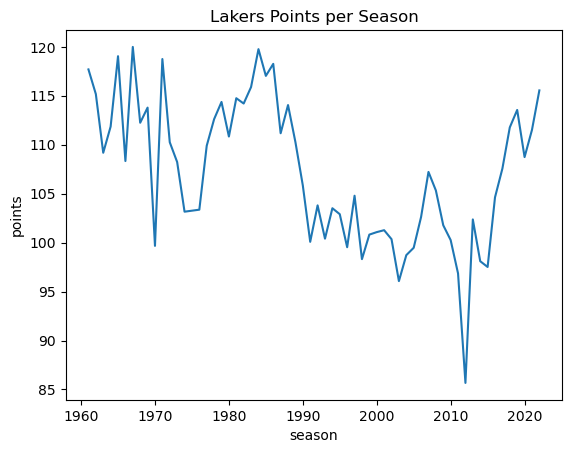

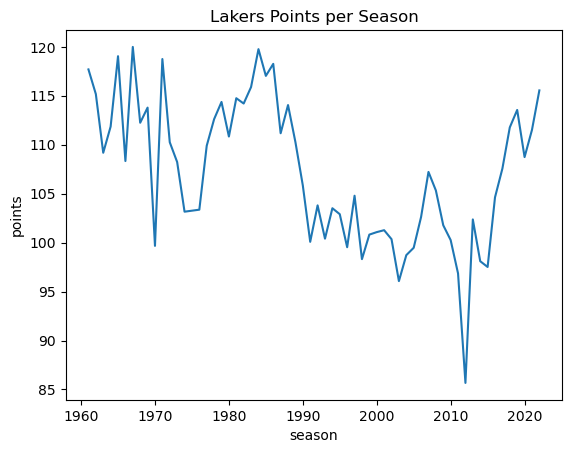

In [17]:
import pandas as pd

# step 1: reshape games → long format
home = df[['game_date','team_name_home','team_abbreviation_home','pts_home']].rename(
    columns={'team_name_home':'team','team_abbreviation_home':'team_abbr','pts_home':'points'}
)
away = df[['game_date','team_name_away','team_abbreviation_away','pts_away']].rename(
    columns={'team_name_away':'team','team_abbreviation_away':'team_abbr','pts_away':'points'}
)

games_long = pd.concat([home, away], ignore_index=True)

# step 2: convert game_date to datetime
games_long['game_date'] = pd.to_datetime(games_long['game_date'])

# step 3: create nba season variable:
# if game is in Oct–Dec → season = year(game_date)
# if game is in Jan–Jun → season = year(game_date)-1
games_long['season'] = games_long['game_date'].dt.year.where(
    games_long['game_date'].dt.month >= 10,
    games_long['game_date'].dt.year - 1
)

# step 4: filter Lakers
lal = games_long[games_long['team_abbr'] == 'LAL']

# step 5: aggregate mean points per season
season_pts = lal.groupby('season', as_index=False)['points'].mean()

# step 6: plot
from nba.viz import lineplot
ax = lineplot(season_pts, x='season', y='points', title="Lakers Points per Season")
ax.figure



### Interpretation of *Lakers Points per Season*

The line chart shows the average points scored per season by the Los Angeles Lakers from the 1960s to the 2020s.

---

#### 1. High-Scoring Period (1960s–1980s)
- The Lakers consistently scored **over 110 points per game** during this period.
- This reflects a **fast-paced offensive style**, particularly during the *“Showtime”* era with Magic Johnson and Kareem Abdul-Jabbar.

#### 2. Scoring Decline (1990s–2010s)
- A clear **downward trend** appears starting in the early 1990s.
- The NBA as a whole shifted toward **slower pace and stronger defense**, reducing scoring league-wide.
- During the Kobe & Shaq era and the later Kobe-led teams, scoring hovered around **100 points per game**.

#### 3. Sharp Drop Around 2013–2014
- There is a significant dip to **below 90 points**, indicating a downturn in offensive performance.
- This corresponds to the **post-Kobe injury phase** and roster rebuilding years.

#### 4. Recent Increase (Late 2010s–2020s)
- Scoring rises again to **110+ points** in recent seasons.
- This aligns with the modern NBA trend of:
  - **Higher pace**
  - **More spacing & 3-point shooting**
  - **Analytics-driven offensive strategies**

---

### Key Takeaways
- Lakers scoring trends closely follow **league-wide shifts in play style**.
- Highest scoring eras coincide with **strong star power** and **fast offensive systems**.
- The recent rise reflects the **modern offensive resurgence** across the NBA.
